## TI3160TU: Natural Language Processing - Vector Semantics and Word Embeddings Lab

In this hands-on lab, we will explore methods that allow us to assess the similarity of documents/words in a corpus. We are going to focus on three approaches/methods: 

1. **Term Frequency - Inverse Document Frequency (TF-IDF):** A measure that reflects how important a word is to a document in a corpus. The TF-IDF value increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus, thus helping to adjust for the fact that some words appear more frequently in general.
2. **Pointwise Mutual Information (PMI):** A metric that measures the association between two words. High PMI values indicate that the co-occurrence of two words is more than what would be expected if they were independent. 
3. **Word2vec models:** A popular neural network model for learning word embeddings in large texts. It captures the semantic meaning of words by representing them as vectors in a high-dimensional space. Words with similar meanings tend to be closer in this space, making it useful for tasks like word similarity and analogy.

To demonstrate these methods, we are going to use a dataset that includes all tweets made by Donald Trump (available at: https://drive.google.com/file/d/1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6/view?usp=sharing). 

### 0. Loading the dataset

In [1]:
import pandas as pd

# the dataset is in a csv file so lets use Panda's built in function to load a csv into a dataframe
tweetsdf = pd.read_csv('tweets_01-08-2021.csv') # load the tweets using Pandas
tweetsdf.iloc[0] # lets see what its included in the dataset

id                                           98454970654916608
text         Republicans and Democrats have both created ou...
isRetweet                                                    f
isDeleted                                                    f
device                                               TweetDeck
favorites                                                   49
retweets                                                   255
date                                       2011-08-02 18:07:48
isFlagged                                                    f
Name: 0, dtype: object

There are a bunch of metadata included in the dataset. Here we are interested in the "text" field which corresponds to the tweet text.

In [2]:
tweetsdf.shape

(56571, 9)

The dataset includes data for 56,571 tweets. So our corpus has 56K documents in it! 

### 1. Term Frequency - Inverse Document Frequency (TF-IDF)

To convert our documents to a matrix of TF-IDF features we are going to use the readily available **TfidfVectorizer** function from Sklearn. The most important parameters of this function are:
1. *lowercase:* A boolean that indicates if the documents should be converted to lowercase. By defaults its true
2. *max_df:* When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold. Default value is 1.0.
3. *min_df:* When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. Default value is 1
3. *max_features:* If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. Otherwise, all features are used. Default value is None
4. *stop_words:* You can pass a string or a list of words that will be considered stopwords and will be removed from the documents. Default value is None

In [3]:
# import the function to extract TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer


# define the behavior of our TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', # remove english stopwords
                                  max_df=1.0, # essentially does not remove any feature
                                  min_df=1, # essentially does not remove any feature
                                  max_features=None) #essentially does not remove any feature

# Compute TF-IDF vectors for each tweet
tfidf_matrix = tfidf_vectorizer.fit_transform(tweetsdf['text'].tolist())
tfidf_matrix.shape

(56571, 58705)

Now we have converted our raw corpus to a TF-IDF matrix. Each row corresponds to a tweet and each column correspond to a TF-IDF feature, which in this case corresponds to a word that exists in the vocabulary that is created from the words that appear in our dataset. As we can see from the matrix's shape, our TF-IDF representations include a very large number of features, in this case 58K features (see #columns).

To identify what each feature corresponds to, we can access the vocabulary of our TfidfVectorizer. It includes the mapping between the word and the feature index in our matrix. Lets print some of the words in our vocabulary and their corresponding index.

In [4]:
# how to know what each column corresponds to
feature_names = tfidf_vectorizer.vocabulary_
print(dict(list(feature_names.items())[:5]))

{'republicans': 42983, 'democrats': 14724, 'created': 13156, 'economic': 16919, 'problems': 40394}


This means that column 42983 corresponds to the word "republicans", column 14724 corresponds to the word "democrats", etc.

Usually, we do not use so large number of features so we need to reduce the number of features (i.e., the dimensionality of this matrix). Many features are not very informative and can be excluded. There are three ways to reduce the number of features in Sklearn's TF-IDF implementation:
1. **Change max_df parameter:** The max_df parameter in Sklearn's TF-IDF Vectorizer refers to the maximum document frequency. It's used to filter out terms that have a document frequency strictly higher than the given threshold. This can be in terms of a proportion (0.0-1.0) or an absolute number. For instance, setting max_df to 0.8 would filter out terms that appear in 80% of the documents. This is useful for excluding terms that are too common and are unlikely to carry much meaning.
2. **Change min_df parameter:** The min_df parameter refers to the minimum document frequency. Words that have a document frequency strictly lower than the given threshold will be ignored. Like max_df, this threshold can be a proportion or an absolute count. Setting min_df to 0.1, for example, would exclude words that appear in less than 10% of the documents. This is helpful for filtering out rare terms that might be typos or are too infrequent to analyze.
3. **Set max_features parameter:** This parameter is straightforward. It sets the maximum number of features (i.e., unique terms or words) to be retained. When building the vocabulary, it only considers the top max_features ordered by term frequency across the corpus. For example, setting max_features to 1000 would only use the 1000 terms that appear most frequently across the dataset. It's a way to limit the dimensionality of the output and can be useful when you have computational constraints or when working with a very large dataset.

In [5]:
# Lets see an example with setting the max_df and min_df parameters
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english', 
    max_df=0.8,        # Ignore terms that appear in more than 80% of the documents
    min_df=5,       # Ignore terms that appear in less than 5 documents
)

tfidf_matrix2 = tfidf_vectorizer.fit_transform(tweetsdf['text'].tolist())
tfidf_matrix2.shape

(56571, 9703)

Here, we observe that by setting the max_df to 0.8 and min_df to 5, we reduced the number of features and the dimensionality of the matrix from 58K to 9.7K. If, we want to further reduce, we can tweak these parameters or set only the max_features parameter. For instance, if we want to extract a TF-IDF matrix with max 5000 features we can do the following:

In [6]:
# Lets see an example with setting the max_features parameter
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english', 
    max_features=5000 # Consider only the top 5000 terms by term frequency
)

tfidf_matrix3 = tfidf_vectorizer.fit_transform(tweetsdf['text'].tolist())
tfidf_matrix3.shape

(56571, 5000)

We confirm the number of features by inspecting the shape of our matrix. Now, having converted our corpus into TF-IDF representations we can use them for various NLP tasks like performing classification tasks, assessing the similarity between documents, clustering the documents to understand the main topics of discussion, etc.

### 1.1 Using TF-IDF representations to assess document similarity

Here, we will demonstrate how we can use our TF-IDF representations to assess similarity between documents. We will follow the next steps:
1. We provide an example document (query_document) for which we aim to find the document that is more similar in our corpus.
2. We convert the query document to a TF-IDF representation similarly to what we did before
3. We calculate the cosine similarities between our query TF-IDF representation and all TF-IDF representations in our corpus
4. We find the document in our corpus that has the highest cosine similarity with the query document and we print it along with the cosine similarit

Lets see how we can implement these steps using Sklearn.

In [7]:
# import the method from sklearn that allow us to calculate all pairwise cosine similarities
from sklearn.metrics.pairwise import cosine_similarity

# here we have a test document. we want to find the tweet from Donald Trump that is more similar to this document
query_document = "Hillary Clinton is a crooked person"

# first we need to convert our query document to a TF-IDF representation like before
query_tfidf = tfidf_vectorizer.transform([query_document])

# we calculate all cosine similarities between the query TF-IDF representation and all documents in our corpus (their TF-IDF representations)
cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix3).flatten()

# find the index of the document that has the highest cosine similarity
most_similar_doc_idx = cosine_similarities.argmax()

# print the results
print(f"The most similar document to '{query_document}' is: '{tweetsdf['text'].tolist()[most_similar_doc_idx]}'\n")
print(f"Cosine Similarity of these two documents is: '{cosine_similarities[most_similar_doc_idx]}'")


The most similar document to 'Hillary Clinton is a crooked person' is: 'Crooked Hillary Clinton, perhaps the most dishonest person to have ever run for the presidency, is also one of the all time great enablers!'

Cosine Similarity of these two documents is: '0.6787896811118255'


### 1.2 Using TF-IDF representations to make exploratory analysis (e.g., by clustering the representations)

Instead of assessing the similarity of a single query document to our corpus, we can analyze our corpus in an exploratory manner by creating clusters of documents that are semantically similar based on their TF-IDF representations. To do this, we are going to follow the next steps:

1. First, sample our corpus to reduce its size (usually we cluster the entire dataset but for purposes of this demo we will sample randomly 5K documents to speed up the process of clustering).
2. We will a use a standard clustering algorithm (DBSCAN) to group the documents into clusters based on their cosine similarities of the TF-IDF representations.
3. Print a maximum of 10 documents for each cluster (except cluster -1, which is the noise cluster that includes documents that are not clustered with any other documents).

Lets see how we can implement these steps!

In [8]:
from sklearn.cluster import DBSCAN
import numpy as np

# text of our tweets in the dataset
tweets = tweetsdf['text'].tolist()

# Randomly sample 5000 rows from the tfidf_matrix
random_indices = np.random.choice(tfidf_matrix3.shape[0], 5000, replace=False)
sampled_tfidf = tfidf_matrix3[random_indices]

# cluster the sampled TF-IDF representations
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
clusters = dbscan.fit_predict(sampled_tfidf)

# find the cluster of each document
labels = dbscan.labels_

# Filter and print the tweets that are not in the noise cluster
clusters = {}
for idx, label in enumerate(labels):
    if label != -1:
        clusters.setdefault(label, []).append(tweets[random_indices[idx]])

for cluster_id, cluster_tweets in clusters.items():
    print(f"\nCluster {cluster_id}:\n{'-'*40}")
    for tweet in cluster_tweets[:10]:
        print(tweet)


Cluster 0:
----------------------------------------
"""@PlaisanceAnn: @realDonaldTrump Trump for President!!!"""
@scottlara1961 Have a Happy Birthday.
WITCH HUNT!
https://t.co/WjbNIvW96r
https://t.co/Mn4EJ7Jbh8
#TrumpAdvice http://t.co/f0Sjhe80OL
"""@BobMenziesGolf: @realDonaldTrump @TylerClodfelter It should be locker #1, in my opinion! #Trump2016"""
https://t.co/2PoLkxQ8KE
Thank you for all of your support! Let's #MakeAmericaGreatAgain! #Trump2016 https://t.co/G7o6b0cfZz
https://t.co/P46CNUBicX

Cluster 4:
----------------------------------------
@sdoocy @BroRay You always look great on TV, even without a Trump tie!
"""@JVince81: @bforrealstevens  GovChristie @realDonaldTrump That tie is awesome. I need that tie. Where can I get it?""  MACY'S"
"""@benwiley3: @realDonaldTrump @Macys my Donald Trump tie is my prized possession in my closet!""  Great!"
"""@Jesus_Mohammad: @realDonaldTrump should I get the red Donald trump tie or the blue Donald trump tie???"" Get them both at Macy's-th

### **Exercise: Use TF-IDF representations for classification tasks**

Using TF-IDF representations for classification tasks is a common approach. In this exercise, you are asked to perform a classification task using TF-IDF. We are going to re-use the dataset that we used for the Classification tasks lab, which includes a dataset of movie reviews and their sentiment. The steps are the following:

1. Load the IMDB reviews dataset that is a labeled dataset including movie reviews and their sentiment
2. Vectorize the reviews: Convert the reviews into a matrix of TF-IDF features.
3. Train-Test Split: Split your data into a training set and a test set.
4. Train a Classifier: Use the training data to train a logistic regression classifier.
5. Evaluate the Classifier: Test the classifier on the test set to see how well it performs.

In [1]:
### Insert your code here

### 2. Pointwise Mutual Information (PMI)

Pointwise Mutual Information (PMI) is a measure used in natural language processing and text mining. PMI is frequently used to identify strong associations between words in large text corpora.

## Formula

Given two words \(x\) and \(y\), the PMI between them is defined as:

$\text{PMI}(x, y) = \log \left( \frac{p(x, y)}{p(x)p(y)} \right)$


Where:
- $p(x, y)$ is the joint probability of \(x\) and \(y\) occurring together.
- $p(x)$ and $p(y)$ are the probabilities of \(x\) and \(y\) occurring independently.

## Interpretation

If \(x\) and \(y\) are independent, their PMI will be 0. If they co-occur more frequently than expected under independence, PMI will be positive; if less frequently, it will be negative.


## Procedure

To calculate PMI, first, we are gonna preprocess the corpus (remove stopwords, tokenize, etc.), then calculate occurrence and co-occurrence of words, and then use the above formula to calculate the PMI between two words.

#### 2.1 Preprocess

We make some standard pre-processing on the corpus by removing special characters, URLs, making everything lowercase, and tokenizing the documents into words.

In [10]:
import re
from nltk.corpus import stopwords
from collections import defaultdict, Counter
import math 
stop_words = set(stopwords.words('english'))

# our corpus
docs = tweetsdf['text'].tolist()

# pre-process each document 
preprocessed_docs = []
for doc in docs:
    res = doc.lower() # lowercase
    res = re.sub(r'[^a-zA-Z ]', '', res) # remove numbers/punctuation
    res = re.sub(r'http\S+', '', res) # remove URLs 
    words = []
    for word in res.split(' '): 
        if len(word)>0 and word not in stop_words:
            words.append(word)
    preprocessed_docs.append(words)

#### 2.2 Calculate Frequencies of Words and Co-occurrence of Words

In [11]:
# function to calculate word frequencies and word co-occurrences on a corpus
# INPUT: Tokenized corpus
# OUTPUT: Two dictionaries that include word frequencies and word co-occurences in the corpus
def calculate_frequencies(tokenized_corpus):
    # dictionaries to hold the word frequencies and word co-occurrences
    word_freq = defaultdict(int)
    cooccur_freq = defaultdict(int)
    
    # calculate word frequencies
    for doc in tokenized_corpus:
        unique_words = set(doc)
        for word in unique_words:
            word_freq[word] += 1
            
        # calculate co-occurrence of words
        for i, word1 in enumerate(unique_words):
            for j, word2 in enumerate(unique_words):
                if i < j:
                    cooccur_freq[(word1, word2)] += 1
                    cooccur_freq[(word2, word1)] += 1  # since it's symmetric
    # return the two dictionaries
    return word_freq, cooccur_freq

# calculate the word frequencies and word co-occurences on our corpus
word_freq, cooccur_freq = calculate_frequencies(preprocessed_docs)


#### 2.3. Calculate PMI

In [12]:
# function that calculate the PMI between two words based on the calculated frequencies/co-occurences
# INPUT: The two words, the frequency dictionary, the co-occurrence dictionary, and the number of documents in the corpus
# OUTPUT: The PMI value of the two words
def pmi(word1, word2, word_freq, cooccur_freq, total_docs):
    
    # calculate probability for word1
    prob_word1 = word_freq[word1] / total_docs
    
    # calculate probability for word2
    prob_word2 = word_freq[word2] / total_docs
    
    # calculate probability of co-occurence for word1 and word2
    prob_word1_word2 = cooccur_freq[(word1, word2)] / total_docs

    # calculate and return PMI 
    return math.log(prob_word1_word2 / (prob_word1 * prob_word2), 2) if prob_word1_word2 > 0 else 0

# lets calculate the PMI on an example
word1, word2 = "republicans", "democrats" 
print(f"PMI({word1}, {word2}) =", pmi(word1, word2, word_freq, cooccur_freq, len(preprocessed_docs)))

PMI(republicans, democrats) = 3.0387057970973492


In [13]:
word1, word2 = "election", "trump" 
print(f"PMI({word1}, {word2}) =", pmi(word1, word2, word_freq, cooccur_freq, len(preprocessed_docs)))

PMI(election, trump) = 0.04765173853628407


This positive value indicates that the word "election" co-occurs with the word "trump" more often than would be expected if the two words were independent of each other. However, the value is relatively close to 0, suggesting that the association is not particularly strong.

In [14]:
word1, word2 = "election", "clinton" 
print(f"PMI({word1}, {word2}) =", pmi(word1, word2, word_freq, cooccur_freq, len(preprocessed_docs)))

PMI(election, clinton) = 1.330518018899047


This value is considerably higher than the PMI for "election" and "trump", indicating a stronger association between the words "election" and "clinton". The positive value indicates that these two words co-occur more frequently together than would be expected under the assumption of independence.

Based on the PMI values, in the dataset of Trump's tweets, the word "election" is more strongly associated with the word "clinton" than with the word "trump". This suggests that when Trump mentioned the word "election", he was more likely to also mention "clinton" than to mention "trump" in the same context.

### 3. Word2vec models

Word2Vec is a popular NLP approach used for generating dense vector representations of words in large text corpora. These vectors aim to capture the semantic meaning of words, where words with similar meanings are located close to each other in the vector space.

Word2Vec encompasses two main architectures:

1. Continuous Bag of Words (CBOW): Predicts a word given its context.
2. Skip-Gram: Predicts the context (surrounding words) given a word.

### Key Features:
1. **Fixed-size vectors:** Regardless of the vocabulary size, each word is represented as a fixed-size vector (e.g., 300 dimensions).
2. **Cosine similarity:** Word vectors can be compared using cosine similarity to measure how similar they are in terms of meaning.
3. **Semantic Relationships**: One of Word2Vec's famous properties is its ability to perform operations like "King" - "Man" + "Woman" ≈ "Queen".

In this part of the lab, we are going to see how we can use Word2vec models and how we can train our own word2vec models using the Gensim Python library.

##### Library Imports

For Word2Vec model we are going to use the Gensim library. Gensim offers manmy pre-trained word2vec models and an easy interface for training and using Word2vec models. Lets check what pre-trained word2vec models are available on the Gensim library.

In [15]:
import gensim # Python library for using word embedding models
import gensim.downloader # to download pretrained models
from sklearn.manifold import TSNE # dimensionality reduction method
import matplotlib.pyplot as plt # for plotting
import warnings
pd.set_option('display.max_colwidth', 1000)
warnings.filterwarnings('ignore') # no warnings pls :)

print(list(gensim.downloader.info()['models'].keys())) #list the pretrained models available from Gensim

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [16]:
# lets load a pretrained Word2Vec model
w2v = gensim.downloader.load('word2vec-google-news-300')

Having loaded a Word2vec model we are gonna go through some of the basic functionalities:
1. Given a word, extract its vector
2. Given a word, extract its most similar words
3. Demonstrate relationships between word embeddings
4. Visualize embeddings in a 2D space

#### 3.1. Extracting word vectors

After loading a model, we can convert a word into a dense vector based on the trained Word2vec model!

In [17]:
# getting a vector for a specific word
w2v.get_vector('twitter')

array([ 0.10205078, -0.08398438, -0.10546875,  0.09863281, -0.08935547,
       -0.00842285, -0.09570312, -0.31835938,  0.12597656, -0.2578125 ,
       -0.03442383, -0.31445312,  0.03808594,  0.17089844,  0.17773438,
        0.12890625, -0.07714844,  0.01000977, -0.14648438,  0.06298828,
        0.17480469,  0.05908203,  0.46875   , -0.09619141, -0.36328125,
        0.08642578, -0.29101562,  0.14453125, -0.16992188, -0.07324219,
       -0.3125    , -0.02258301,  0.00408936, -0.22558594, -0.08642578,
       -0.16796875, -0.02600098,  0.09472656,  0.18359375,  0.08740234,
        0.18847656, -0.16113281,  0.17285156,  0.29492188,  0.47265625,
       -0.16796875,  0.01635742, -0.0859375 , -0.17871094, -0.01416016,
       -0.16308594,  0.08642578, -0.11621094,  0.4375    ,  0.34960938,
       -0.07958984, -0.01904297,  0.08447266, -0.03857422, -0.6171875 ,
        0.15917969, -0.18652344, -0.02587891,  0.00159454, -0.15429688,
       -0.00212097, -0.02441406,  0.06738281,  0.26367188,  0.24

In [18]:
# or simply
w2v['twitter']

array([ 0.10205078, -0.08398438, -0.10546875,  0.09863281, -0.08935547,
       -0.00842285, -0.09570312, -0.31835938,  0.12597656, -0.2578125 ,
       -0.03442383, -0.31445312,  0.03808594,  0.17089844,  0.17773438,
        0.12890625, -0.07714844,  0.01000977, -0.14648438,  0.06298828,
        0.17480469,  0.05908203,  0.46875   , -0.09619141, -0.36328125,
        0.08642578, -0.29101562,  0.14453125, -0.16992188, -0.07324219,
       -0.3125    , -0.02258301,  0.00408936, -0.22558594, -0.08642578,
       -0.16796875, -0.02600098,  0.09472656,  0.18359375,  0.08740234,
        0.18847656, -0.16113281,  0.17285156,  0.29492188,  0.47265625,
       -0.16796875,  0.01635742, -0.0859375 , -0.17871094, -0.01416016,
       -0.16308594,  0.08642578, -0.11621094,  0.4375    ,  0.34960938,
       -0.07958984, -0.01904297,  0.08447266, -0.03857422, -0.6171875 ,
        0.15917969, -0.18652344, -0.02587891,  0.00159454, -0.15429688,
       -0.00212097, -0.02441406,  0.06738281,  0.26367188,  0.24

#### 3.2. Extracting word similarities

After obtaining dense vector representations for words, we can assess the similarity between words. For instance, we can find the most similar words to a word of interest. Gensim offers an easy-to-use interface to do this. Lets see how we can do this.

In [19]:
# getting the most similar words to a term
w2v.most_similar('twitter')

[('Twitter', 0.8908904194831848),
 ('Twitter.com', 0.7536780834197998),
 ('tweet', 0.7431627511978149),
 ('tweeting', 0.7161932587623596),
 ('tweeted', 0.7137226462364197),
 ('facebook', 0.6988551616668701),
 ('tweets', 0.6974530220031738),
 ('Tweeted', 0.6950210332870483),
 ('Tweet', 0.6875007152557373),
 ('Tweeting', 0.6845167279243469)]

In [20]:
# getting the most similar words to a term
w2v.most_similar('twitter', topn=20)

[('Twitter', 0.8908904194831848),
 ('Twitter.com', 0.7536780834197998),
 ('tweet', 0.7431627511978149),
 ('tweeting', 0.7161932587623596),
 ('tweeted', 0.7137226462364197),
 ('facebook', 0.6988551616668701),
 ('tweets', 0.6974530220031738),
 ('Tweeted', 0.6950210332870483),
 ('Tweet', 0.6875007152557373),
 ('Tweeting', 0.6845167279243469),
 ('Tweets', 0.6546129584312439),
 ('Facebook', 0.6483454704284668),
 ('TwitterTwitter', 0.6432195901870728),
 ('twittered', 0.6393427848815918),
 ('micro_blogging_site', 0.6302406787872314),
 ('Twitters', 0.62877357006073),
 ('twitterverse', 0.6279213428497314),
 ('blog', 0.6257337927818298),
 ('Follow_AndroidGuys', 0.6226419806480408),
 ('onTwitter', 0.6222246289253235)]

We can also assess the similarity between two words of interest using the lines below...

In [21]:
w2v.similarity('twitter', '4chan')

0.34480923

In [22]:
w2v.similarity('twitter', 'myspace')

0.5744767

Based on this Word2vec model, MySpace is more semantically similar to Twitter than 4chan!

#### 3.3. Word Relationships


**most_similar_cosmul**: Find the top-N most similar words, using the multiplicative combination objective, proposed by Omer Levy and Yoav Goldberg “Linguistic Regularities in Sparse and Explicit Word Representations”. Positive words still contribute positively towards the similarity, negative words negatively, but with less susceptibility to one large distance dominating the calculation. In the common analogy-solving case, of two positive and one negative examples, this method is equivalent to the “3CosMul” objective (equation (4)) of Levy and Goldberg.


Lets demonstrate the popular example of King and Queen! 

w2v.most_similar_cosmul(positive=['king', 'woman'], negative=['man'])

Do relationships work with countries and cities as well? Lets try with Greece and Italy!

In [23]:
w2v.most_similar_cosmul(positive=['greece', 'rome'], negative=['italy'])

[('athens', 0.8228010535240173),
 ('samuel', 0.8189568519592285),
 ('cro', 0.8184024691581726),
 ('caroline', 0.8162517547607422),
 ('sess', 0.816144585609436),
 ('zz', 0.8157657980918884),
 ('afta', 0.8151275515556335),
 ('tting', 0.8136284947395325),
 ('hev', 0.8132066130638123),
 ('YEO_MAN', 0.8131966590881348)]

#### 3.4. Embedding visualization 

Lets visualize the embeddings in a 2D dimensional space to observe how they are represented in the dimensional space. We are going to use TSNE, which is a dimensionality reduction method that will help us convert our dense representation to 2-dimensions. Then, we are simply going to plot the two dimensions using matplotlib library.

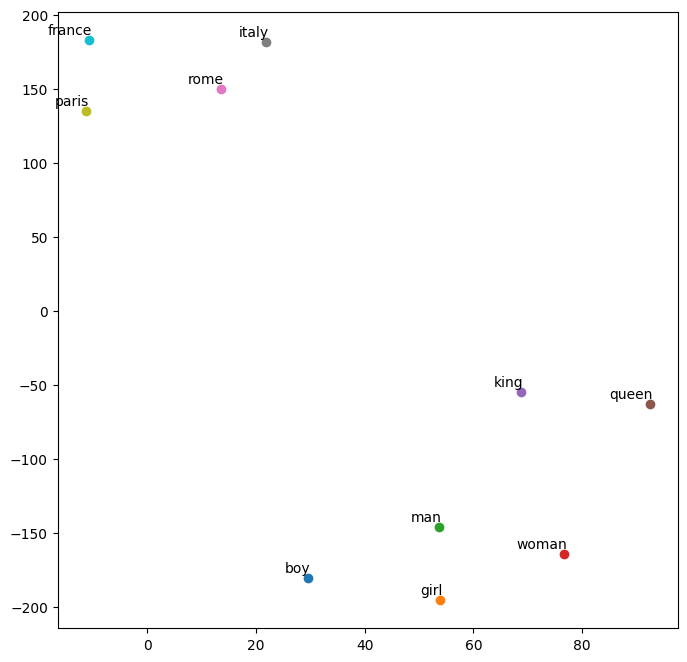

In [24]:
# method to visualize words in a 2D Space

def visualize_embeddings_using_tsne(model, target_words):
    # extract the embeddings given the target words
    embeddings = [model[x] for x in target_words]

    
    # reduce the dimensionality of the embeddings. From 300 to 2
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=128)
    coordinates = tsne_model.fit_transform(np.array(embeddings))

    # extract the x,y coordinates from the reduced embeddings
    x = [i[0] for i in coordinates]
    y = [i[1] for i in coordinates]
    
    # plot the reducted embeddings
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(target_words[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

    
    
targets = ["boy", "girl", "man", "woman", "king", "queen",
            "rome", "italy", "paris", "france" ]

visualize_embeddings_using_tsne(w2v, targets)

#### 3.5 Training our own word2vec models

We will use the same pre-processed corpus that includes Trump's tweets to train a Word2Vec model based on Trump's tweets!

In [25]:
print(docs[0], preprocessed_docs[0])

Republicans and Democrats have both created our economic problems. ['republicans', 'democrats', 'created', 'economic', 'problems']


In [26]:
print(docs[1], preprocessed_docs[1])

I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y ['thrilled', 'back', 'great', 'city', 'charlotte', 'north', 'carolina', 'thousands', 'hardworking', 'american', 'patriots', 'love', 'country', 'cherish', 'values', 'respect', 'laws', 'always', 'put', 'america', 'first', 'thank', 'wonderful', 'evening', 'kag']


In [27]:
# lets define the parameters of our Word2Vec model
import gensim
our_w2v_model = gensim.models.Word2Vec(sentences=preprocessed_docs,
                                        vector_size=100, #dimensionality of the vectors
                                        min_count=10, #Ignore all words with frequency less than this
                                        window=5, #Size of the context window 
                                        epochs= 5, #Number of iterations over the corpus
                                        sg=1, #Whether to use Skip-gram or CBOW (1 for skip-gram, 0 for CBOW)
                                        workers=5, #Number of workers to train the model (faster training on multicore machines)
                                        ) 

In [28]:
our_w2v_model.wv.most_similar('hillary')

[('clinton', 0.8819814324378967),
 ('crooked', 0.8376810550689697),
 ('dnc', 0.7517157196998596),
 ('hillarys', 0.7216495871543884),
 ('acid', 0.7194294929504395),
 ('h', 0.7148081064224243),
 ('firm', 0.7102262377738953),
 ('clintons', 0.7070257663726807),
 ('emails', 0.7049728631973267),
 ('dirt', 0.7003675699234009)]

In [29]:
# having trained a model we can save it to use it later
our_w2v_model.save('trump-tweets.w2v')

In [30]:
# we can load a model with 
trump_model = gensim.models.Word2Vec.load('trump-tweets.w2v')

In [31]:
trump_model.wv.most_similar('hillary')

[('clinton', 0.8819814324378967),
 ('crooked', 0.8376810550689697),
 ('dnc', 0.7517157196998596),
 ('hillarys', 0.7216495871543884),
 ('acid', 0.7194294929504395),
 ('h', 0.7148081064224243),
 ('firm', 0.7102262377738953),
 ('clintons', 0.7070257663726807),
 ('emails', 0.7049728631973267),
 ('dirt', 0.7003675699234009)]

In [32]:
# we can extract the words in the vocabulary using
vocabulary_words = [key for key,value in trump_model.wv.key_to_index.items()]
len(vocabulary_words)

6220

Our Word2vec model has 6,220 words in its vocabulary

In [33]:
print("First word in vocabulary: %s" %(vocabulary_words[0]))

First word in vocabulary: realdonaldtrump


In [34]:
# finding out how many times a word appeared in the corpus
trump_model.wv.get_vecattr('realdonaldtrump', 'count')

10889

### **Exercise: Using the trained Word2Vec model "word2vec-google-news-300", use the Gensim Word2Vec interface to answer the following questions:**
1. Use the Word2Vec model to find the top 20 words most similar to "computers". How do these words reflect different aspects or contexts of "computers"?
2.  Measure the semantic similarity between "peace" and "war" compared to "sun" and "moon" using the Word2Vec model. Think what the differences in similarity tell you about the relationship and contextual connections between these pairs of words in the Google News dataset.
3. Use the Word2Vec model to solve the analogy "book is to reading as music is to what?" Analyze the top results to understand how the model associates music with certain activities or concepts, and think the rationale behind these associations based on the context provided in the Google News dataset.


In [2]:
### Insert your code here

## TI3160TU: Natural Language Processing - Vector Semantics Lab -- END